In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.integrate import odeint
from scipy.stats import multinomial
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import random
import math
import pickle

from matplotlib.colors import DivergingNorm
from matplotlib.colors import TwoSlopeNorm

In [2]:
#ODEs
def groupsir_beta(S,I,R,pbeta,n):
    N = S+I+R
    B = 0
    Sn = S/N
    In = I/N
    Rn = R/N
    for nS in range(1,n):#loop through possible number of susceptibles attending (at least one S and one I attend)
        for nI in range(1,n-nS+1):
            partyp = multinomial.pmf([nS, nI, n-nS-nI], n, p=[Sn,In,Rn])#probability of sampling composition
            expectinf = nS*(1-(1-pbeta)**nI)#expected number of infections
            B = B + partyp*expectinf#add to total infection rate
    return B

def groupsir_beta2(S,I,I2,R,pbeta,n):
    N = S+I+I2+R
    B = 0
    B2 = 0
    Sn = S/N
    In = I/N
    I2n = I2/N
    Rn = R/N            
    for nS in range(1,n):#loop through possible number of susceptibles attending (at least one S and one I attend)
        for nI in range(1,n+1-nS):#0:(np1-k-1)for nI in range(1,n-nS+1):
            for l in range(0,nI+1):
                l2 = nI-l
                partyp = multinomial.pmf([nS, l,l2, n-nS-l-l2], n, p=[Sn,In,I2n,Rn])#probability of sampling composition
                expectinf = nS*(1-(1-pbeta)**(l+l2))#expected number of infections
                partyfactor1 = partyp*(l/(l+l2))
                partyfactor2 = partyp*(l2/(l+l2))
                B = B + partyfactor1*expectinf#add to total infection rate
                B2 = B2 + partyfactor2*expectinf#add to total infection rate
    return B,B2

def groupsir_beta2fit(S,I,I2,R,pbeta,deltaw,n):
    pbetam = pbeta*deltaw
    N = S+I+I2+R
    B = 0
    B2 = 0
    Sn = S/N
    In = I/N
    I2n = I2/N
    Rn = R/N            
    for nS in range(1,n):#loop through possible number of susceptibles attending (at least one S and one I attend)
        for nI in range(1,n+1-nS):#0:(np1-k-1)for nI in range(1,n-nS+1):
            for l in range(0,nI+1):
                l2 = nI-l
                partyp = multinomial.pmf([nS, l,l2, n-nS-l-l2], n, p=[Sn,In,I2n,Rn])#probability of sampling composition
                expectinf = nS*(1-(1-pbeta)**(l)*(1-pbetam)**(l2))
                prob1vsm = (l*pbeta/(l*pbeta+l2*pbetam))
                partyfactor1 = partyp*prob1vsm
                partyfactor2 = partyp*(1-prob1vsm)
                B = B + partyfactor1*expectinf#add to total infection rate
                B2 = B2 + partyfactor2*expectinf#add to total infection rate
    return B,B2
                    
def SIR_n(y, t, N, pbeta, gamma,n):
    S, I, R = y
    In = I/N
    B = groupsir_beta(S,I,R,pbeta,n)
    dSdt = -B
    dIdt = B - gamma * In
    dRdt = gamma * In
    return dSdt, dIdt, dRdt

def SIR_n_norm(y, t, N, pbeta, gamma,n):
    S, I, R = y
    In = I/N
    B = groupsir_beta(S,I,R,pbeta,n)
    dSdt = -B/(.5*n*(n-1))
    dIdt = B/(.5*n*(n-1)) - gamma * In
    dRdt = gamma * In
    return dSdt, dIdt, dRdt

def total_du(n,u,pbeta):
    #n is party size, u goes from 2,3,... party sizes
    nS = n-2#index of focal susceptibles
    focalS = u[nS]
    numsubpop = len(u)//3
    Iidx = numsubpop
    Ridx = 2*numsubpop
    #loop through parties where focalS can attend (smaller or equal in size)
    du = 0
    for currn in range(nS+1):
        currpartysize = currn+2
        otherS = sum(u[currn:Iidx])-focalS
        otherI = sum(u[(Iidx+currn):Ridx])
        otherR = sum(u[(Ridx+currn):])
        du += groupsir_beta(focalS,otherI,otherR+otherS,pbeta,currpartysize)
    return du

def total_du2(n,u,pbeta):
    #n is party size, u goes from 2,3,... party sizes
    nS = n-2#index of focal susceptibles
    focalS = u[nS]
    numsubpop = len(u)//4
    Iidx = numsubpop
    Ridx = 2*numsubpop
    I2idx = 3*numsubpop
    #loop through parties where focalS can attend (smaller or equal in size)
    du = 0
    du2 = 0
    for currn in range(nS+1):
        currpartysize = currn+2
        otherS = sum(u[currn:Iidx])-focalS
        otherI = sum(u[(Iidx+currn):Ridx])
        otherR = sum(u[(Ridx+currn):I2idx])
        otherI2 = sum(u[(I2idx+currn):])
        currdu,currdu2 = groupsir_beta2(focalS,otherI,otherI2,otherR+otherS,pbeta,currpartysize)
        du+=currdu
        du2+=currdu2
    return du,du2

def total_du2fit(n,u,pbeta,deltaw):
    #n is party size, u goes from 2,3,... party sizes
    nS = n-2#index of focal susceptibles
    focalS = u[nS]
    numsubpop = len(u)//4
    Iidx = numsubpop
    Ridx = 2*numsubpop
    I2idx = 3*numsubpop
    #loop through parties where focalS can attend (smaller or equal in size)
    du = 0
    du2 = 0
    for currn in range(nS+1):
        currpartysize = currn+2
        otherS = sum(u[currn:Iidx])-focalS
        otherI = sum(u[(Iidx+currn):Ridx])
        otherR = sum(u[(Ridx+currn):I2idx])
        otherI2 = sum(u[(I2idx+currn):])
        currdu,currdu2 = groupsir_beta2fit(focalS,otherI,otherI2,otherR+otherS,pbeta,deltaw,currpartysize)
        du+=currdu
        du2+=currdu2
    return du,du2

def SIR_party(u,t,pbeta,gamma):
    numsubpop = len(u)//3#number of risk subpop (2,3,4,etc)
    duS = []
    duI = []
    duR = []
    for n in range(numsubpop):
        nparty = n+2
        duS.append(-total_du(nparty,u,pbeta))
        duI.append(total_du(nparty,u,pbeta)-gamma*u[n+numsubpop])
        duR.append(gamma*u[n+numsubpop])
    du = duS + duI + duR
    return du

def SIR_party2(u,t,pbeta,gamma):
    maxparty = len(u)//4+1
    duS = []
    duI = []
    duI2 = []
    duR = []
    for n in range(maxparty-1):
        nparty = n+2
        dutotal1,dutotal2 = total_du2(nparty,u,pbeta)
        duS.append(-(dutotal1+dutotal2))
        duI.append(dutotal1-gamma*u[n+maxparty-1])
        duI2.append(dutotal2-gamma*u[n+3*(maxparty-1)])
        duR.append(gamma*(u[n+maxparty-1]+u[n+3*(maxparty-1)]))#fix gamma
    du = duS + duI + duR + duI2
    return du

def SIR_party2fit(u,t,pbeta,gamma,deltaw):
    maxparty = len(u)//4+1
    duS = []
    duI = []
    duI2 = []
    duR = []
    for n in range(maxparty-1):
        nparty = n+2
        dutotal1,dutotal2 = total_du2fit(nparty,u,pbeta,deltaw)
        duS.append(-(dutotal1+dutotal2))
        duI.append(dutotal1-gamma*u[n+maxparty-1])
        duI2.append(dutotal2-gamma*u[n+3*(maxparty-1)])
        duR.append(gamma*(u[n+maxparty-1]+u[n+3*(maxparty-1)]))#fix gamma
    du = duS + duI + duR + duI2
    return du

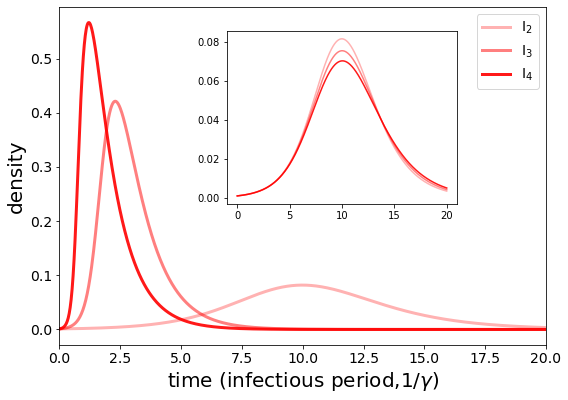

In [3]:
#figure 2a
Ncoeff = 1
N = 1.0*Ncoeff
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 0.001*Ncoeff, 0.0*Ncoeff
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
#pbeta, gamma = 0.1*5*2, 1
pbeta, gamma = 0.8, 1
n = 2
# A grid of time points (in days)
tf = 20
t = np.linspace(0, tf, 1000)
# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret2 = odeint(SIR_n, y0, t, args=(N, pbeta, gamma,2))
S2, I2, R2 = ret2.T

ret3 = odeint(SIR_n, y0, t, args=(N, pbeta, gamma,3))
S3, I3, R3 = ret3.T

ret4 = odeint(SIR_n, y0, t, args=(N, pbeta, gamma,4))
S4, I4, R4 = ret4.T

ret3n = odeint(SIR_n_norm, y0, t, args=(N, pbeta, gamma,3))
S3n, I3n, R3n = ret3n.T

ret4n = odeint(SIR_n_norm, y0, t, args=(N, pbeta, gamma,4))
S4n, I4n, R4n = ret4n.T

# Plot results
fig = plt.figure(1, figsize=(8,16))

# Plot theta as a function of time
ax = fig.add_subplot(311)

ax.plot(t, I2, 'r', alpha=0.3, lw=3, label='I$_2$',color = 'red')
ax.plot(t, I3, 'r', alpha=0.5, lw=3, label='I$_3$',color = 'red')
ax.plot(t, I4, 'r', alpha=0.9, lw=3, label='I$_4$',color = 'red')
ax.set_xlim(0,tf)#tf)
legend = ax.legend(fontsize=14,loc='best')
ax.set_xlabel('time (infectious period,1/$\gamma$)',fontsize=20)
ax.set_ylabel('density',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
left, bottom, width, height = [0.4, 0.82, 0.4, 0.15]
ax2 = fig.add_axes([left, bottom, width, height])# Draw the plots
ax2.plot(t,I2,alpha=0.3,label='I$_2$',color = 'red')
ax2.plot(t,I3n,alpha=0.5,label='I$_3$',color = 'red')
ax2.plot(t,I4n,alpha=0.9,label='I$_4$',color = 'red')

#plt.savefig('../figures/group_Icompare.pdf',bbox_inches='tight')
plt.show()

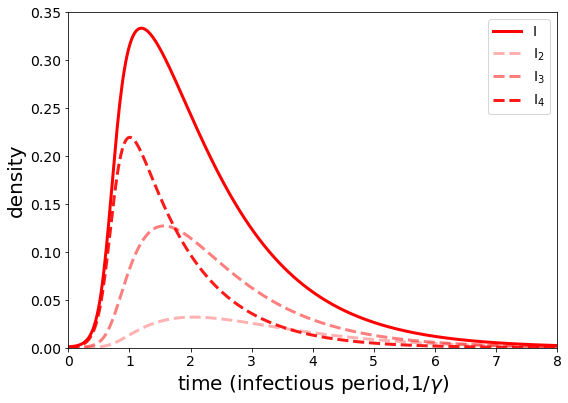

In [4]:
#figure 2b
maxparty = 4 #actually +1, start counting at party size=2

Ncoeff = 1
N = 1.0*Ncoeff
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 0.001*Ncoeff, 0.0*Ncoeff
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
#pbeta, gamma = 0.1*5*2, 1
pbeta, gamma = 0.25, 1
n = 2
tf = 20
t = np.linspace(0, tf, 1001)

Nleft = N-I0

Sapp = []#zeros(3*(maxparty-1))
Iapp = []
Rapp = []
for j in range(maxparty-1):# 1:maxparty-1
    Sapp.append(Nleft/(maxparty-1))
    Iapp.append(I0/(maxparty-1))
    Rapp.append(0)
u0 = Sapp+Iapp+Rapp
# Initial conditions vector
#y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(SIR_party, u0, t, args=(pbeta, gamma))
uf = ret.T

#Plot results
fig = plt.figure(1, figsize=(8,16))
# Plot theta as a function of time
ax = fig.add_subplot(311)
ax.plot(t, uf[3]+uf[4]+uf[5], alpha=1.0, lw=3, label='I',color = 'red')
ax.plot(t, uf[3],'--', alpha=0.3, lw=3, label='I$_2$',color = 'red')
ax.plot(t, uf[4],'--', alpha=0.5, lw=3, label='I$_3$',color = 'red')
ax.plot(t, uf[5],'--', alpha=0.9, lw=3, label='I$_4$',color = 'red')
ax.set_ylim(0,0.35)
ax.set_xlim(0,8)#tf)
legend = ax.legend(fontsize=14)
ax.set_xlabel('time (infectious period,1/$\gamma$)',fontsize=20)
ax.set_ylabel('density',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()

#plt.savefig('../figures/SIR4_inf.pdf',bbox_inches='tight')
plt.show()

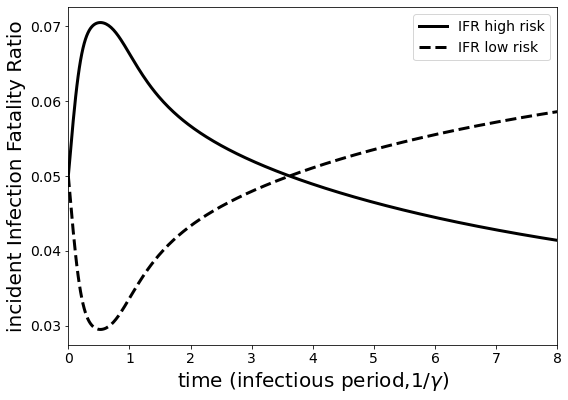

In [5]:
#figure 2c
fig = plt.figure(1, figsize=(8,16))
# Plot theta as a function of time
cfrvec = [0.25,0.5,.75]
ax = fig.add_subplot(311)
#ax.plot(t, uf[3]+uf[4]+uf[5], alpha=1.0, lw=3, label='$I$',color = 'red')
ax.plot(t, .1*(cfrvec[0]*uf[3]+cfrvec[1]*uf[4]+cfrvec[2]*uf[5])/(uf[3]+uf[4]+uf[5]),'-', alpha=1, lw=3, label='IFR high risk',color = 'black')
ax.plot(t, .1*(cfrvec[2]*uf[3]+cfrvec[1]*uf[4]+cfrvec[0]*uf[5])/(uf[3]+uf[4]+uf[5]),'--', alpha=1, lw=3, label='IFR low risk',color = 'black')

#ax.set_ylim(0,1)
ax.set_xlim(0,8)#tf)
legend = ax.legend(fontsize=14)
#ax1.plot(t, psoln[:,0])
ax.set_xlabel('time (infectious period,1/$\gamma$)',fontsize=20)
ax.set_ylabel('incident Infection Fatality Ratio',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)
#plt.title('Incident CFR -- avoid', fontsize=20)
plt.tight_layout()

#plt.savefig('../figures/SIR4_ifr_inc.pdf',bbox_inches='tight')
plt.show()

In [6]:
#mutations
maxparty = 4 #actually +1, start counting at party size=2

N = 1.0
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 0.001, 0.0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
pbeta, gamma = .25, 1
tf = 8
t = np.linspace(0, tf, 1000)

Nleft = N-I0

Sapp = []#zeros(3*(maxparty-1))
Iapp = []
Rapp = []
I2app = []
for j in range(maxparty-1):# 1:maxparty-1
    Sapp.append(Nleft/(maxparty-1))
    Iapp.append(I0/(maxparty-1))
    Rapp.append(0)
    I2app.append(0)
u0 = Sapp+Iapp+Rapp
# Initial conditions vector
#y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(SIR_party, u0, t, args=(pbeta, gamma))
uf = ret.T

Sog = np.sum(np.array(uf[0:maxparty-1]),axis=0)
Iog = np.sum(np.array(uf[maxparty-1:2*(maxparty-1)]),axis=0)
Rog = np.sum(np.array(uf[2*(maxparty-1):3*(maxparty-1)]),axis=0)


shiftidx=0
perturbvec =[10**-9]
currtstart = .25
#allmaxshift = np.empty([len(perturbvec),len(introt)])

I0mut = N*perturbvec[0]
#print(currtidx/len(introt))
tstartidx = np.where(t<=currtstart)[0][-1]
tbefore = t[0:tstartidx]
tleftover = t[tstartidx:]
prevu0 = [x[0:tstartidx] for x in uf]
curru0 = [x[tstartidx] for x in uf]
currI0 = curru0[maxparty-1:2*(maxparty-1)]
curru0 = curru0+[0]*(maxparty-1)
shiftamount = min(I0mut,curru0[2*(maxparty-1)-1-shiftidx])
#shiftamount = 0
curru0[2*(maxparty-1)-1-shiftidx]-=shiftamount
curru0[len(curru0)-1-shiftidx]+=shiftamount
retmut = odeint(SIR_party2, curru0, tleftover, args=(pbeta, gamma))
ufmut = retmut.T
I_notmut = np.sum(np.array(ufmut[maxparty-1:2*(maxparty-1)]),axis=0)
I_mut = np.sum(np.array(ufmut[3*(maxparty-1):4*(maxparty-1)]),axis=0)
prevI_notmut = np.sum(np.array(prevu0[maxparty-1:2*(maxparty-1)]),axis=0)

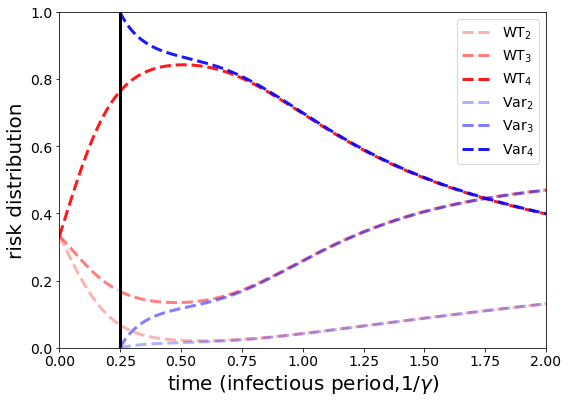

In [7]:
I_notmutvec = np.array(ufmut[maxparty-1:2*(maxparty-1)])
I_mutvec = np.array(ufmut[3*(maxparty-1):4*(maxparty-1)])
prevI_notmutvec = np.array(prevu0[maxparty-1:2*(maxparty-1)])

fig = plt.figure(1, figsize=(8,16))
ax = fig.add_subplot(311)
# Plot theta as a function of time
ax.plot(tbefore, np.divide(prevI_notmutvec[0],prevI_notmut),'--', alpha=0.3, lw=3,label = "WT$_2$", color = 'red')
ax.plot(tbefore, np.divide(prevI_notmutvec[1],prevI_notmut),'--', alpha=0.5, lw=3,label = "WT$_3$", color = 'red')
ax.plot(tbefore, np.divide(prevI_notmutvec[2],prevI_notmut),'--', alpha=0.9, lw=3,label = "WT$_4$", color = 'red')
ax.plot(tleftover, np.divide(I_notmutvec[0],I_notmut),'--', alpha=0.3, lw=3, color = 'red')
ax.plot(tleftover, np.divide(I_notmutvec[1],I_notmut),'--', alpha=0.5, lw=3, color = 'red')
ax.plot(tleftover, np.divide(I_notmutvec[2],I_notmut),'--', alpha=0.9, lw=3, color = 'red')

ax.plot(tleftover, np.divide(I_mutvec[0],I_mut),'--', alpha=0.3, lw=3,label = "Var$_2$", color = 'blue')
ax.plot(tleftover, np.divide(I_mutvec[1],I_mut),'--', alpha=0.5, lw=3,label = "Var$_3$", color = 'blue')
ax.plot(tleftover, np.divide(I_mutvec[2],I_mut),'--', alpha=0.9, lw=3,label = "Var$_4$", color = 'blue')
ax.set_ylim(0,1)
ax.set_xlim(0,2)#tf)
plt.axvline(x=min(tleftover),lw=3,color='black')
legend = ax.legend(fontsize=14)
ax.set_xlabel('time (infectious period,1/$\gamma$)',fontsize=20)
ax.set_ylabel('risk distribution',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()

#plt.savefig('../figures/mutgrowth_riskdist.pdf',bbox_inches='tight')
plt.show()

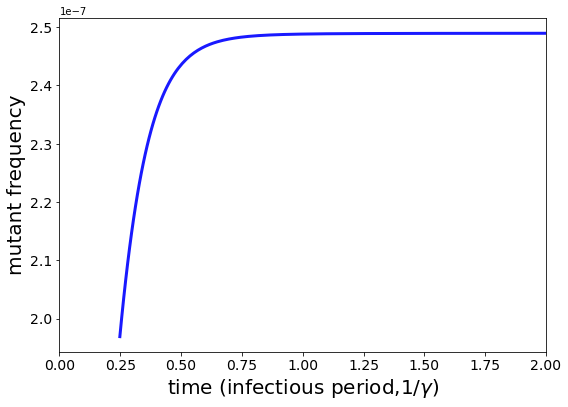

In [8]:
fig = plt.figure(1, figsize=(8,16))
ax = fig.add_subplot(311)
# Plot theta as a function of time
ax.plot(tleftover, np.divide(np.array(I_mut),np.array(I_mut)+np.array(I_notmut)), alpha=0.9, lw=3,color = 'blue')
ax.set_xlim(0,2)
ax.set_xlabel('time (infectious period,1/$\gamma$)',fontsize=20)
ax.set_ylabel('mutant frequency',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()

#plt.savefig('../figures/mutgrowth_rel.pdf',bbox_inches='tight')
plt.show()

In [9]:
#mutations
maxparty = 4 #actually +1, start counting at party size=2

N = 1.0
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 0.001, 0.0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
pbeta, gamma = .25, 1
tf = 8
t = np.linspace(0, tf, 1000)

deltacoeff=1.5
deltaw = deltacoeff
n = 2
# A grid of time points (in days)
tf = 10
t = np.linspace(0, tf, 1000)

Nleft = N-I0

Sapp = []#zeros(3*(maxparty-1))
Iapp = []
Rapp = []
I2app = []
for j in range(maxparty-1):# 1:maxparty-1
    Sapp.append(Nleft/(maxparty-1))
    Iapp.append(I0/(maxparty-1))
    Rapp.append(0)
    I2app.append(0)
u0 = Sapp+Iapp+Rapp
# Initial conditions vector
#y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(SIR_party, u0, t, args=(pbeta, gamma))
uf = ret.T
Sog = np.sum(np.array(uf[0:maxparty-1]),axis=0)
Iog = np.sum(np.array(uf[maxparty-1:2*(maxparty-1)]),axis=0)
Rog = np.sum(np.array(uf[2*(maxparty-1):3*(maxparty-1)]),axis=0)



perturbvec =[10**-9]
currtstart = .25

I0mut = N*perturbvec[0]
tstartidx = np.where(t<=currtstart)[0][-1]
tbefore = t[0:tstartidx]
tleftover = t[tstartidx:]
prevu0 = [x[0:tstartidx] for x in uf]
prevI_notmut = np.sum(np.array(prevu0[maxparty-1:2*(maxparty-1)]),axis=0)
curru0 = [x[tstartidx] for x in uf]
currI0 = curru0[maxparty-1:2*(maxparty-1)]
curru0 = curru0+[0]*(maxparty-1)
curru0_og = curru0
#move to 4
curru0 = curru0_og
curru0 = [x[tstartidx] for x in uf]
currI0 = curru0[maxparty-1:2*(maxparty-1)]
curru0 = curru0+[0]*(maxparty-1)
shiftidx=0
shiftamount = min(I0mut,curru0[2*(maxparty-1)-1-shiftidx])
curru0[2*(maxparty-1)-1-shiftidx]-=shiftamount
curru0[len(curru0)-1-shiftidx]+=shiftamount
retmut4 = odeint(SIR_party2fit, curru0, tleftover, args=(pbeta, gamma,deltaw))
ufmut4 = retmut4.T
I_notmut4 = np.sum(np.array(ufmut4[maxparty-1:2*(maxparty-1)]),axis=0)
I_mut4 = np.sum(np.array(ufmut4[3*(maxparty-1):4*(maxparty-1)]),axis=0)
S_mut4 = np.sum(np.array(ufmut4[3*(maxparty-1):4*(maxparty-1)]),axis=0)
#move to 3
shiftidx=1
curru0 = curru0_og
curru0 = [x[tstartidx] for x in uf]
currI0 = curru0[maxparty-1:2*(maxparty-1)]
curru0 = curru0+[0]*(maxparty-1)
shiftamount = min(I0mut,curru0[2*(maxparty-1)-1-shiftidx])
curru0[2*(maxparty-1)-1-shiftidx]-=shiftamount
curru0[len(curru0)-1-shiftidx]+=shiftamount
retmut3 = odeint(SIR_party2fit, curru0, tleftover, args=(pbeta, gamma,deltaw))
ufmut3 = retmut3.T
I_notmut3 = np.sum(np.array(ufmut3[maxparty-1:2*(maxparty-1)]),axis=0)
I_mut3 = np.sum(np.array(ufmut3[3*(maxparty-1):4*(maxparty-1)]),axis=0)
#move to 2
shiftidx=2
curru0 = curru0_og
curru0 = [x[tstartidx] for x in uf]
currI0 = curru0[maxparty-1:2*(maxparty-1)]
curru0 = curru0+[0]*(maxparty-1)
shiftamount = min(I0mut,curru0[2*(maxparty-1)-1-shiftidx])
curru0[2*(maxparty-1)-1-shiftidx]-=shiftamount
curru0[len(curru0)-1-shiftidx]+=shiftamount
retmut2 = odeint(SIR_party2fit, curru0, tleftover, args=(pbeta, gamma,deltaw))
ufmut2 = retmut2.T
I_notmut2 = np.sum(np.array(ufmut2[maxparty-1:2*(maxparty-1)]),axis=0)
I_mut2 = np.sum(np.array(ufmut2[3*(maxparty-1):4*(maxparty-1)]),axis=0)
freqdyn4 = np.divide(np.array(I_mut4),np.array(I_mut4)+np.array(I_notmut4))
freqdyn3 = np.divide(np.array(I_mut3),np.array(I_mut3)+np.array(I_notmut3))
freqdyn2 = np.divide(np.array(I_mut2),np.array(I_mut2)+np.array(I_notmut2))

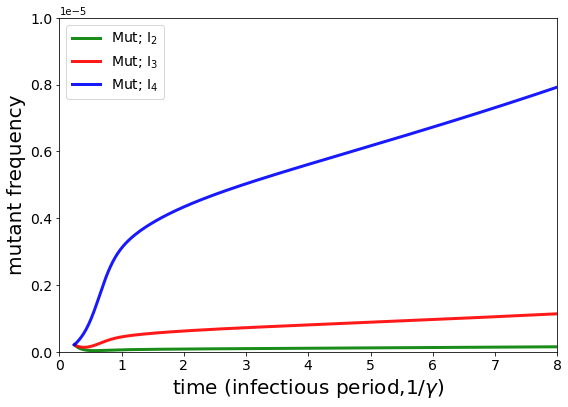

In [10]:
fig = plt.figure(1, figsize=(8,16))
ax = fig.add_subplot(311)

ax.plot(tleftover, np.divide(np.array(I_mut2),np.array(I_mut2)+np.array(I_notmut2)), label="Mut; I$_2$",alpha=0.9, lw=3,color = 'green')
ax.plot(tleftover, np.divide(np.array(I_mut3),np.array(I_mut3)+np.array(I_notmut3)), label="Mut; I$_3$",alpha=0.9, lw=3,color = 'red')
ax.plot(tleftover, np.divide(np.array(I_mut4),np.array(I_mut4)+np.array(I_notmut4)), label="Mut; I$_4$",alpha=0.9, lw=3,color = 'blue')

ax.set_xlim(0,2)

legend = ax.legend(fontsize=14,loc='upper left')
ax.set_xlabel('time (infectious period,1/$\gamma$)',fontsize=20)
ax.set_ylabel('mutant frequency',fontsize=20)
ax.set_ylim(0,1E-5)
ax.set_xlim(0,8)#tf)
ax.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()

#plt.savefig('../figures/mutgrowth_rel_fitdiff_'+str(deltacoeff)+'_lin.pdf',bbox_inches='tight')
plt.show()

In [11]:
#stochastic dynamics
def myflatten(l):
    currflat = [item for sublist in l for item in sublist]
    return currflat

def initIpop(Idens):
    mIpop=[None]*len(Idens)
    nextidx = 0
    Iidxs = []
    Irisk = []
    for cnt,currIdens in enumerate(Idens):
        curridx = list(range(nextidx,nextidx+currIdens))
        mIpop[cnt] = curridx
        Iidxs.append(curridx)
        Irisk.append([cnt]*currIdens)
        nextidx+=currIdens
    return(mIpop,Iidxs,Irisk)
    
def risksir_ibm(groupsizedist,riskpop,I0pop,pbeta,pgamma):
    #initialize populations
    maxparty = len(riskpop)+1
    N = sum(riskpop)
    numI = sum(I0pop)
    assert len(riskpop)==len(I0pop), "riskpop and I0pop need to be same length"
    for currrisk,currI0 in zip(riskpop,I0pop):
        assert currI0 <= currrisk, "too many initially infected in a subpopulation"
    numsubpop = len(I0pop)
    partyvec = list(range(numsubpop))
    Iidx = numsubpop
    Ridx = 2*numsubpop
    mIpop,Iidxs,Irisk = initIpop(I0pop)
    Iidxs = myflatten(Iidxs)
    Irisk = myflatten(Irisk)
    It = [0]*len(Iidxs)
    Ianc = [-1]*len(Iidxs)
    SIRmat = np.zeros((3,maxparty-1),dtype=int)
    SIRmat[0,:] = np.array(riskpop)-np.array(I0pop)
    SIRmat[1,:] = np.array(I0pop)
    nextIidx = numI
    cntnextevent = 0
    recoverI = []
    recoverIt = []
    while numI>0:
        cntnextevent+=1
        if random.random()<pgamma:#recovery
            Ivec = SIRmat[1,:]
            I = sum(Ivec)#total I
            if random.random()<(I/N):
                #choose which risk dist it comes from
                currriskIidx = random.choices(partyvec,weights=Ivec,k=1)[0]
                recoverIidx = mIpop[currriskIidx].pop(random.choice(list(range(len(mIpop[currriskIidx])))))
                recoverI.append(recoverIidx)
                recoverIt.append(cntnextevent)
                SIRmat[1,currriskIidx]-=1
                SIRmat[2,currriskIidx]+=1
                numI-=1
        else:#party time
            currpartyidx = random.choices(partyvec,weights=groupsizedist,k=1)[0]#party size
            currpartysize = 2+currpartyidx
            currSIRmat = SIRmat[:,currpartyidx:]
            partySIRweight = np.sum(currSIRmat,axis=1)
            attendSIRidx = random.sample([0,1,2], counts=list(map(int,partySIRweight)), k=currpartysize)
            numSatparty = attendSIRidx.count(0)
            numIatparty = attendSIRidx.count(1)
            if (numSatparty>0) & (numIatparty>0):
                numSinfected = np.random.binomial(numSatparty,1-(1-pbeta)**numIatparty)
                if numSinfected>0:
                    possSweight = currSIRmat[0,:]
                    possIweight = currSIRmat[1,:]
                    #sample I idxs in attendance
                    Icanattend = myflatten(mIpop[currpartyidx:])
                    Iattend = random.sample(Icanattend,k=numIatparty)#sample from population
                    Iinfect = random.choices(Iattend,k=numSinfected)#sample attending infected w/ replacement
                    Sinfectrisk = random.sample(partyvec[currpartyidx:],k=numSinfected,counts=list(map(int,possSweight)))
                    for Iinf,Srisk in zip(Iinfect,Sinfectrisk):
                        #loop through infections and update state variables
                        Ianc.append(Iinf)
                        It.append(cntnextevent)
                        SIRmat[0,Srisk] -= 1
                        SIRmat[1,Srisk] += 1
                        Iidxs.append(nextIidx)
                        Irisk.append(Srisk)
                        mIpop[Srisk].append(nextIidx)
                        numI+=1
                        nextIidx+=1
    return Ianc,Iidxs,Irisk,It,recoverI,recoverIt

def getancestors(startchild,giveinfectlist,getinfectlist):
    lastparent = startchild
    npget = np.array(getinfectlist)
    npgive = np.array(giveinfectlist)
    allparents =[]
    while (lastparent!=-1):
        lastparent = npgive[npget==lastparent][0]
        allparents.append(lastparent)
    return allparents


def getchildren(startancestor,giveinfectlist,getinfectlist):
    npget = np.array(getinfectlist)
    npgive = np.array(giveinfectlist)
    currchildren = [startancestor]
    allchildren = currchildren
    while len(currchildren)>0:
        currchildren = npget[np.isin(npgive,currchildren)]
        allchildren.extend(list(currchildren))
    return allchildren

def getlineagedyn(Iidxs,It,recoverI,recoverIt,lineageidx):
    npIt = np.array(It)
    npIidxs = np.array(Iidxs)
    nprecoverIt = np.array(recoverIt)
    nprecoverI = np.array(recoverI)
    combt = list(set(It+recoverIt))
    combt = sorted(combt)
    currN = 0
    currlin = 0
    Ndyn = []
    lindyn = []
    for currIt in combt:
        if currIt in recoverIt:#recovery
            recovidx = nprecoverI[nprecoverIt==currIt]
            if recovidx in lineageidx:
                currlin-=1
            else:
                currN-=1
        else:#infect
            currinfect = npIidxs[npIt==currIt]
            currinflin = sum(np.isin(currinfect,lineageidx))
            currN+=len(currinfect)-currinflin
            currlin+=currinflin
        lindyn.append(currlin)
        Ndyn.append(currN)
    linfracdyn = np.divide(lindyn[:-1],np.array(Ndyn[:-1])+np.array(lindyn[:-1]))
    return(combt[:-1],linfracdyn)
        
def getIdyn(Iidxs,It,recoverI,recoverIt,Irisk):
    unirisk = np.unique(Irisk)
    npIt = np.array(It)
    npIidxs = np.array(Iidxs)
    npIrisk = np.array(Irisk)
    nprecoverIt = np.array(recoverIt)
    nprecoverI = np.array(recoverI)
    combt = list(set(It+recoverIt))
    combt = sorted(combt)
    Imat =  np.zeros((len(unirisk),len(combt)),dtype=int)
    priorvec = np.zeros((len(unirisk),1),dtype=int)
    for curridx,currIt in enumerate(combt):
        if currIt in recoverIt:#recovery
            recovidx = nprecoverI[nprecoverIt==currIt]
            recovrisk = npIrisk[npIidxs==recovidx]
            recovlogic = unirisk==recovrisk
            priorvec[recovlogic]= priorvec[recovlogic]-1
        else:#infect
            currinfectrisk = npIrisk[npIt==currIt]
            for infectrisk in currinfectrisk:
                infectlogic = unirisk==infectrisk
                priorvec[infectlogic]= priorvec[infectlogic]+1
        Imat[:,curridx:curridx+1] = priorvec
    return(combt,Imat)

def t2infint(t,riskpop,pgamma):
    Nstoch = sum(riskpop)
    t2intfactor = Nstoch/pgamma
    newt = [currt/t2intfactor for currt in t]
    return(newt)
    
def risksir_ibm_exampledyn(currseed,pbeta,pgamma):
    random.seed(currseed)
    np.random.seed(currseed)
    Iidxs = [0]
    riskpop = [5000,5000,5000]
    I0pop = [2,2,2]
    while len(Iidxs)<4000:#hard code so that we get a legit run
        Ianc,Iidxs,Irisk,It,recoverI,recoverIt = risksir_ibm([1,1,1],riskpop,I0pop,pbeta,pgamma)
    return(Ianc,Iidxs,Irisk,It,recoverI,recoverIt)

In [21]:
#generate stochastic data
rngvec = range(1300,1550)#range(1300,1400)#range(1300,1400)
cumIfracvec = np.arange(.1,.61,step = .05)#np.arange(.1,.6,step = .05)#np.arange(.1,.6,step = .05)
minfracvec = np.arange(.001,.101,step=.001)#np.linspace(.001,.002,2)#np.linspace(.001,.10,101)#np.arange(.001,.05,step=.001)
logdevvec = np.arange(.1,1.01,step=.05)#np.linspace(.1,.5,41)##np.arange(.1,1.0,step=.05)

In [15]:
#run through it

outputdict = dict()
tdict = dict()
for cumI in cumIfracvec:
    outputdict[str(cumI)] = np.empty((len(minfracvec), len(logdevvec), len(rngvec)))
    outputdict[str(cumI)][:] = np.nan
    tdict[str(cumI)] = np.empty((len(minfracvec), len(logdevvec), len(rngvec)))
    tdict[str(cumI)][:] = np.nan

#sim parameters
numpops = 5
pbeta = .125/2#.05#
pgamma = .125/2
totpop = 15000
popperpop = (np.ceil(totpop/numpops)).astype(int)
riskpop = np.array([5000,0,5000,0,5000])#(np.ones(numpops)*popperpop).astype(int)#np.array([7500,0,7500])##[5000,5000,5000]#np.array([7500,0,0,7500])#
I0pop = np.array([2,0,2,0,2])#(np.ones(numpops)).astype(int)#np.array([2,0,2])##[2,2,2]#np.array([2,0,0,2])#
for k,currrng in enumerate(rngvec):
    random.seed(currrng)#1339
    np.random.seed(currrng)#1339 pub
    groupsizedist = np.array([1,0,1,0,1]).astype(int)
    Ianc,Iidxs,Irisk,It,recoverI,recoverIt = risksir_ibm(groupsizedist,riskpop,I0pop,pbeta,pgamma)
    combt,Idyn = getIdyn(Iidxs,It,recoverI,recoverIt,Irisk)
    for cumI in cumIfracvec:
        cumIidx = math.floor(cumI*sum(riskpop))-1#python
        tcum = It[cumIidx]
        tcuminfint = t2infint([tcum],riskpop,pgamma)
        combtinfint = t2infint(combt,riskpop,pgamma)
        prevrecovered = np.array(recoverI)[np.array(recoverIt)<tcum]
        extantIidx = list(set(Iidxs[:cumIidx+1])-set(prevrecovered))
        extantIrisk = np.array(Irisk)[np.isin(Iidxs,extantIidx)]
        numcurrI = len(extantIidx)
        allancestors = []
        for extantchild in extantIidx:
            currancestors = getancestors(extantchild,Ianc,Iidxs)
            allancestors.append(currancestors[:])

        #get all lineages for current infections, track time of emergence and
        uniancestors = np.unique(myflatten(allancestors))
        uniancestors = uniancestors[uniancestors!=-1]
        lindifft = []
        linsize = []
        lindiffrisk = []
        for currancestor in uniancestors:
            havechildlogic = [currancestor in sublist for sublist in allancestors]
            currnumchildren = sum(havechildlogic)
            currextantIidx = np.array(extantIidx)[havechildlogic]
            currt = np.array(It)[np.array(Iidxs)==currancestor][0]#min(mydf.time[mydf.child==currancestor].values)
            lindiffrisk.append(np.mean(extantIrisk[havechildlogic])-np.mean(extantIrisk[np.logical_not(havechildlogic)]))
            lindifft.append(tcum-currt)
            linsize.append(currnumchildren)

        lindiffrisk = np.array(lindiffrisk)
        linfrac = np.divide(linsize,numcurrI)
        rate2hist = np.divide(linsize,lindifft)

        for i,currfracvec in enumerate(minfracvec):
            for j, currlogdev in enumerate(logdevvec):
                currlogic = (linfrac>currfracvec) & (linfrac<(currfracvec*(1+currlogdev)))
                currlindifft = np.array(lindifft)[currlogic]
                currgrowthrate = np.array(linfrac)[currlogic]/currlindifft
                currriskev = np.array(lindiffrisk)[currlogic]
                if len(currriskev)>0:
                    outputdict[str(cumI)][i,j,k] = currriskev[currgrowthrate==max(currgrowthrate)][0]
                    tdict[str(cumI)][i,j,k] = currlindifft[currgrowthrate==max(currgrowthrate)][0]

In [16]:
#save
datastr = 'split_6'
with open('../data/outputdict_'+datastr+'.pickle', 'wb') as f:
    pickle.dump(outputdict, f)
with open('../data/tdict_'+datastr+'.pickle', 'wb') as g:
    pickle.dump(tdict, g)

In [19]:
#load
datastr = 'split_6'
with open('../data/outputdict_'+datastr+'.pickle', 'rb') as f:
    loaded_dict = pickle.load(f)
#with open('../data/tdict_'+datastr+'.pickle', 'rb') as g:
#    loaded_tdict = pickle.load(g)

0.1
0.20000000000000004
0.30000000000000004
0.40000000000000013
0.5000000000000001
0.6000000000000002


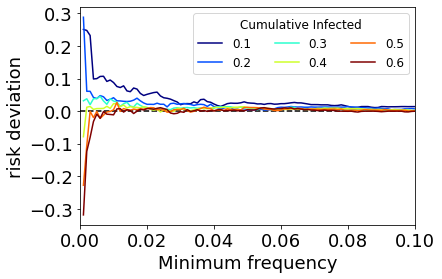

In [22]:
from matplotlib import cm
#outputdict = np.load('../data/allsurveillance_split_6.npy',allow_pickle=True)
logdevidx = 18#15#18
minfracidx = 9
logdevlogic = logdevvec==logdevvec[logdevidx]
alphavec = np.linspace(.1,.7,len(loaded_dict))

col = plt.cm.jet(np.linspace(0,1,len(loaded_dict))) 
plt.axhline(y=0,color='k',linestyle='--')
allmed = np.zeros([len(minfracvec),len(loaded_dict)])
for i,currkey in enumerate(loaded_dict):
    if i%2==0:
        print(currkey)
        currdict = loaded_dict[currkey]
        currline = currdict[:,logdevlogic,:]
        currmed = np.nanmedian(currline,axis=2)
        allmed[:,i] = np.squeeze(currmed)
        plt.plot(minfracvec,currmed,color=col[i],label=currkey[:3])
        
plt.legend(title='Cumulative Infected',ncol=3,fontsize=12,title_fontsize=12)
plt.xlim([0,.1])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Minimum frequency',fontsize=18)
plt.ylabel('risk deviation',fontsize=18)
#plt.savefig('../figures/riskbiasfreq_'+datastr+'_'+str(logdevidx)+'.pdf',bbox_inches='tight')
plt.show()

In [12]:
#GET STOCHASTIC DYNAMICS
random.seed(1337)#1339
np.random.seed(1337)#1339 pub
riskpop = np.ones(3, dtype=int)*1500#[5000,5000,5000]
I0pop = 2*np.ones(3,dtype=int)#[2,2,2]
pbeta = .1#.05#
pgamma = .1#.3
Ianc,Iidxs,Irisk,It,recoverI,recoverIt = risksir_ibm(np.ones(3,dtype=int),riskpop,I0pop,pbeta,pgamma)

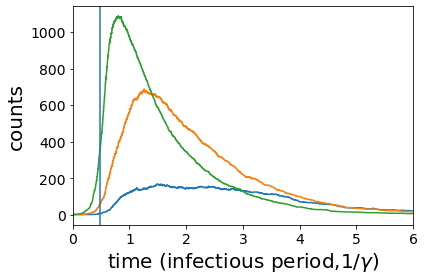

In [13]:
combt,Idyn = getIdyn(Iidxs,It,recoverI,recoverIt,Irisk)
cumIfrac = .1#.4#.1
cumIidx = math.floor(cumIfrac*sum(riskpop))-1#python
tcum = It[cumIidx]
tcuminfint = t2infint([tcum],riskpop,pgamma)
combtinfint = t2infint(combt,riskpop,pgamma)

fig,ax = plt.subplots()
ax.plot(combtinfint,np.transpose(Idyn))

plt.axvline(x=tcuminfint)
ax.set_xlabel('time (infectious period,1/$\gamma$)',fontsize=20)
ax.set_ylabel('counts',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlim([0,6])
plt.tight_layout()
plt.show()

In [14]:
minfreq = .02
maxfreq = .05

cumIidx = math.floor(cumIfrac*sum(riskpop))-1#python
tcum = It[cumIidx]
prevrecovered = np.array(recoverI)[np.array(recoverIt)<tcum]
extantIidx = list(set(Iidxs[:cumIidx+1])-set(prevrecovered))
extantIrisk = np.array(Irisk)[np.isin(Iidxs,extantIidx)]
numcurrI = len(extantIidx)
allancestors = []
for extantchild in extantIidx:
    currancestors = getancestors(extantchild,Ianc,Iidxs)
    allancestors.append(currancestors[:])

#get all lineages for current infections, track time of emergence and
uniancestors = np.unique(myflatten(allancestors))
uniancestors = uniancestors[uniancestors!=-1]
lindifft = []
linsize = []
lindiffrisk = []
for currancestor in uniancestors:
    havechildlogic = [currancestor in sublist for sublist in allancestors]
    currnumchildren = sum(havechildlogic)
    currextantIidx = np.array(extantIidx)[havechildlogic]
    currt = np.array(It)[np.array(Iidxs)==currancestor][0]#min(mydf.time[mydf.child==currancestor].values)
    lindiffrisk.append(np.mean(extantIrisk[havechildlogic])-np.mean(extantIrisk[np.logical_not(havechildlogic)]))
    Iidxs,Irisk
    lindifft.append(tcum-currt)
    linsize.append(currnumchildren)

lindiffrisk = np.array(lindiffrisk)
linfrac = np.divide(linsize,numcurrI)
rate2hist = np.divide(linsize,lindifft)

Nstoch=sum(riskpop)
t2infintfactor = Nstoch/(pgamma)
linfracmin = max([10/numcurrI,minfreq])
linfracmax = max([20/numcurrI,maxfreq])
selectlogic = (np.array(linfrac)>=linfracmin) & (np.array(linfrac)<=linfracmax)
maxphyidx = np.nonzero((rate2hist==max(rate2hist[selectlogic])) & selectlogic)[0]
maxancestor = uniancestors[maxphyidx][0]
allancestorchildren = getchildren(maxancestor,Ianc,Iidxs)
ancestorchildlogic = np.isin(Iidxs,allancestorchildren)
combt,linfracmat = getIdyn(Iidxs,It,recoverI,recoverIt,ancestorchildlogic)
linfracdyn = linfracmat[1,:]/(np.sum(linfracmat,axis=0))

<ipython-input-14-c857eb9176b7>:45: RuntimeWarning: invalid value encountered in true_divide
  linfracdyn = linfracmat[1,:]/(np.sum(linfracmat,axis=0))


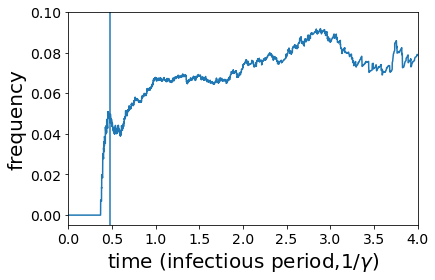

In [16]:
#linfracdyn
fig,ax = plt.subplots()
ax.plot(combtinfint,linfracdyn)
plt.axvline(x=tcuminfint)

ax.set_xlabel('time (infectious period,1/$\gamma$)',fontsize=20)
ax.set_ylabel('frequency',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
ax.set_xlim([0,4])
#ax.set_ylim([0,.022])
plt.savefig('../figures/dyn_fastgrowingvariant.pdf',bbox_inches='tight')
plt.show()

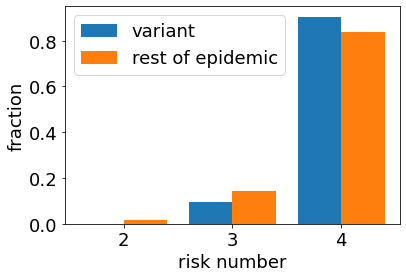

In [18]:
#KEEP but UPDATE
x = np.array(list(range(2,2+len(riskpop))))
npextantIidx = np.array(extantIidx)
notlin = npextantIidx[np.isin(npextantIidx,np.array(allancestorchildren),invert=True)]
inlin = npextantIidx[np.isin(npextantIidx,np.array(allancestorchildren))]
linhist = []
resthist = []
for currparty in range(len(riskpop)):
    allriskidx = np.array(Iidxs)[np.array(Irisk)==currparty]
    linhist.append(sum(np.isin(inlin,allriskidx)))
    resthist.append(sum(np.isin(notlin,allriskidx)))
y1 = np.array(linhist)/sum(linhist)
y2 = np.array(resthist)/sum(resthist)

# plot data in grouped manner of bar type
width = .4
plt.bar(x-.2, y1, width)
plt.bar(x+.2, y2, width)
plt.legend(['variant','rest of epidemic'],fontsize=18)
plt.xticks(x,fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('risk number',fontsize=18)
plt.ylabel('fraction',fontsize=18)
plt.savefig('../figures/riskdist_examplefastgrowingvariant.pdf',bbox_inches='tight')
plt.show()

In [1647]:
def fastestlindyn(cumIfrac,minfreq,logdev,tvec,riskpop,pgamma,It,recoverIt,recoverI,Iidxs,Ianc,Irisk):
    combt = list(set(It+recoverIt))
    combt = sorted(combt)
    cumIidx = math.floor(cumIfrac*sum(riskpop))-1#python
    tcum = It[cumIidx]
    tcuminfint = t2infint([tcum],riskpop,pgamma)
    combtinfint = t2infint(combt,riskpop,pgamma)

    prevrecovered = np.array(recoverI)[np.array(recoverIt)<tcum]
    extantIidx = list(set(Iidxs[:cumIidx+1])-set(prevrecovered))
    numcurrI = len(extantIidx)
    extantIrisk = np.array(Irisk)[np.isin(Iidxs,extantIidx)]
    allancestors = []
    for extantchild in extantIidx:
        currancestors = getancestors(extantchild,Ianc,Iidxs)
        allancestors.append(currancestors[:])

    #get all lineages for current infections, track time of emergence and
    uniancestors = np.unique(myflatten(allancestors))
    uniancestors = uniancestors[uniancestors!=-1]#remove MRCA/emergence strain
    lindifft = []
    linsize = []
    lindiffrisk = []
    #loop through each ancestor and calculate resulting clade dynamics
    for currancestor in uniancestors:
        havechildlogic = [currancestor in sublist for sublist in allancestors]
        currnumchildren = sum(havechildlogic)
        currextantIidx = np.array(extantIidx)[havechildlogic]
        currt = np.array(It)[np.array(Iidxs)==currancestor][0]
        lindifft.append(tcum-currt)
        linsize.append(currnumchildren)
        lindiffrisk.append(np.mean(extantIrisk[havechildlogic])-np.mean(extantIrisk[np.logical_not(havechildlogic)]))
    #get lineage frequencies and rates of emergence
    linfrac = np.divide(linsize,numcurrI)
    rate2hist = np.divide(linsize,lindifft)
    #Filter by input freuqency and bandwidth. Removed filtering by time, use lindifft to add it back
    linfracmin = max([10/numcurrI,minfreq])# at least 10 individuals
    linfracmax = max([20/numcurrI,minfreq*logdev])# at least 20 individuals
    selectlogic = (np.array(linfrac)>=linfracmin) & (np.array(linfrac)<=linfracmax)
    
    #keep for deviation calculation, figure out output
    lindiffrisk = np.array(lindiffrisk)
    deltavarvec = np.full(len(tvec), np.nan)
    if sum(selectlogic)>0:
        #Get fastest growing lineage 
        maxphyidx = np.nonzero((rate2hist==max(rate2hist[selectlogic])) & selectlogic)[0]
        #MRCA for fastest clade
        maxancestor = uniancestors[maxphyidx][0]
        #get all children of this clade
        allancestorchildren = getchildren(maxancestor,Ianc,Iidxs)
        ancestorchildlogic = np.isin(Iidxs,allancestorchildren)
        #get lineage dynamics by assigning lineage to 1 and 0 for else, then track 
        combt,linfracmat = getIdyn(Iidxs,It,recoverI,recoverIt,ancestorchildlogic)
        linfracdyn = linfracmat[1,:]/(np.sum(linfracmat,axis=0))
        combtlogic = np.array(combt)>=tcum
        combtsend = np.array(combt)[combtlogic]
        combtsend = (combtsend-combtsend[0])/t2infintfactor
        currlinfracdyn = np.array(linfracdyn)[combtlogic]

        for tidx,tderp in enumerate(tvec):
            currlogic = combtsend<=tderp
            
            deltavarvec[tidx] = currlinfracdyn[currlogic][-1]

        deltavarvec = deltavarvec-deltavarvec[0]

    return(deltavarvec)

            

In [24]:
#DO IT FULL SIMMMMM
minfreqvec = [.02,.04]#[.01,.02,.03,.04,.05,.06]
mincumvec = [.1,.2,.3]#[.1,.15,.2,.25,.3]
logdev = 1
tvec = np.arange(0,2,.01)
rngvec = range(1300,1550)

pbeta = .125/2#.05#
pgamma = .125/2
totpop = 15000
#Kpopperpop = (np.ceil(totpop/numpops)).astype(int)
riskpop = np.array([5000,0,5000,0,5000])#(np.ones(numpops)*popperpop).astype(int)#np.array([7500,0,7500])##[5000,5000,5000]#np.array([7500,0,0,7500])#
I0pop = np.array([2,0,2,0,2])#(np.ones(numpops)).astype(int)#np.array([2,0,2])##[2,2,2]#np.array([2,0,0,2])#
groupsizedist = np.array([1,0,1,0,1]).astype(int)

Nstoch=sum(riskpop)
t2infintfactor = Nstoch/(pgamma)
#fullsim matrices
alldeltavar = np.empty((len(minfreqvec),len(mincumvec)), dtype=object)
alldiffrisk = np.empty((len(minfreqvec),len(mincumvec)), dtype=object)
#initialize
for i,currminfreq in enumerate(minfreqvec):
    for j,currcum in enumerate(mincumvec):
        alldeltavar[i,j] = np.full((len(rngvec),len(tvec)),np.nan)
        alldiffrisk[i,j] = np.full((len(rngvec),1),np.nan)
        
for k,currrng in enumerate(rngvec):
    print(currrng)
    random.seed(currrng)
    np.random.seed(currrng)
    Ianc,Iidxs,Irisk,It,recoverI,recoverIt = risksir_ibm(groupsizedist,riskpop,I0pop,pbeta,pgamma)
    combt,Idyn = getIdyn(Iidxs,It,recoverI,recoverIt,Irisk)
    for j,cumI in enumerate(mincumvec):
        cumIidx = math.floor(cumI*sum(riskpop))-1#python
        tcum = It[cumIidx]
        tcuminfint = t2infint([tcum],riskpop,pgamma)
        combtinfint = t2infint(combt,riskpop,pgamma)
        prevrecovered = np.array(recoverI)[np.array(recoverIt)<tcum]
        extantIidx = list(set(Iidxs[:cumIidx+1])-set(prevrecovered))
        extantIrisk = np.array(Irisk)[np.isin(Iidxs,extantIidx)]
        numcurrI = len(extantIidx)
        allancestors = []
        for extantchild in extantIidx:
            currancestors = getancestors(extantchild,Ianc,Iidxs)
            allancestors.append(currancestors[:])
        
        #get all lineages for current infections, track time of emergence and
        uniancestors = np.unique(myflatten(allancestors))
        uniancestors = uniancestors[uniancestors!=-1]
        lindifft = []
        linsize = []
        lindiffrisk = []
        for currancestor in uniancestors:
            havechildlogic = [currancestor in sublist for sublist in allancestors]
            currnumchildren = sum(havechildlogic)
            currextantIidx = np.array(extantIidx)[havechildlogic]
            currt = np.array(It)[np.array(Iidxs)==currancestor][0]#min(mydf.time[mydf.child==currancestor].values)
            lindiffrisk.append(np.mean(extantIrisk[havechildlogic])-np.mean(extantIrisk[np.logical_not(havechildlogic)]))
            lindifft.append(tcum-currt)
            linsize.append(currnumchildren)

        lindiffrisk = np.array(lindiffrisk)
        linfrac = np.divide(linsize,numcurrI)
        rate2hist = np.divide(linsize,lindifft)

        for i,currfracvec in enumerate(minfreqvec):

            #fix this
            selectlogic = (linfrac>=currfracvec) & (linfrac<=(currfracvec*(1+logdev)))
            #keep for deviation calculation, figure out output
            currdeltavarvec = np.full(len(tvec), np.nan)
            if sum(selectlogic)>0:
                #Get fastest growing lineage
                maxphylogic = (rate2hist==max(rate2hist[selectlogic])) & selectlogic
                maxphyidx = np.nonzero(maxphylogic)[0]
                currdiffrisk = lindiffrisk[maxphylogic][0]
                #MRCA for fastest clade
                maxancestor = uniancestors[maxphyidx][0]
                #get all children of this clade
                allancestorchildren = getchildren(maxancestor,Ianc,Iidxs)
                ancestorchildlogic = np.isin(Iidxs,allancestorchildren)
                #get lineage dynamics by assigning lineage to 1 and 0 for else, then track 
                combt,linfracmat = getIdyn(Iidxs,It,recoverI,recoverIt,ancestorchildlogic)
                linfracdyn = linfracmat[1,:]/(np.sum(linfracmat,axis=0))
                combtlogic = np.array(combt)>=tcum
                combtsend = np.array(combt)[combtlogic]
                combtsend = (combtsend-combtsend[0])/t2infintfactor
                currlinfracdyn = np.array(linfracdyn)[combtlogic]

                for tidx,tderp in enumerate(tvec):
                    currlogic = combtsend<=tderp
                    currdeltavarvec[tidx] = currlinfracdyn[currlogic][-1]

                currdeltavar = currdeltavarvec-currdeltavarvec[0]
                alldeltavar[i,j][k,:] = currdeltavar
                alldiffrisk[i,j][k] = currdiffrisk


1300


<ipython-input-24-bf23baa2511c>:84: RuntimeWarning: invalid value encountered in true_divide
  linfracdyn = linfracmat[1,:]/(np.sum(linfracmat,axis=0))


1301
1302
1303
1304
1305
1306
1307
1308
1309
1310
1311
1312
1313
1314
1315
1316
1317
1318
1319
1320
1321
1322
1323
1324
1325
1326
1327
1328
1329
1330
1331
1332
1333
1334
1335
1336
1337
1338
1339
1340
1341
1342
1343
1344
1345
1346
1347
1348
1349
1350
1351
1352
1353
1354
1355
1356
1357
1358
1359
1360
1361
1362
1363
1364
1365
1366
1367
1368
1369
1370
1371
1372
1373
1374
1375
1376
1377
1378
1379
1380
1381
1382
1383
1384
1385
1386
1387
1388
1389
1390
1391
1392
1393
1394
1395
1396
1397
1398
1399
1400
1401
1402
1403
1404
1405
1406
1407
1408
1409
1410
1411
1412
1413
1414
1415
1416
1417
1418
1419
1420
1421
1422
1423
1424
1425
1426
1427
1428
1429
1430
1431
1432
1433
1434
1435
1436
1437
1438
1439
1440
1441
1442
1443
1444
1445
1446
1447
1448
1449
1450
1451
1452
1453
1454
1455
1456
1457
1458
1459
1460
1461
1462
1463
1464
1465
1466
1467
1468
1469
1470
1471
1472
1473
1474
1475
1476
1477
1478
1479
1480
1481
1482
1483
1484
1485
1486
1487
1488
1489
1490
1491
1492
1493
1494
1495
1496
1497
1498
1499
1500


0.02 0.1
0.02 0.2
0.02 0.3
0.04 0.1
0.04 0.2
0.04 0.3


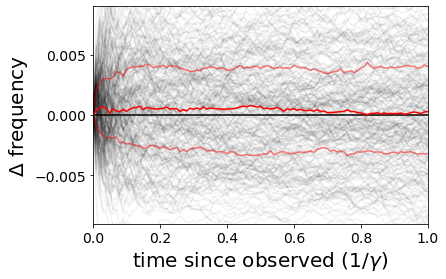

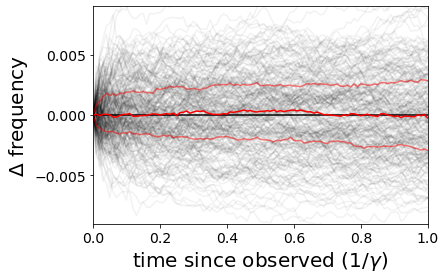

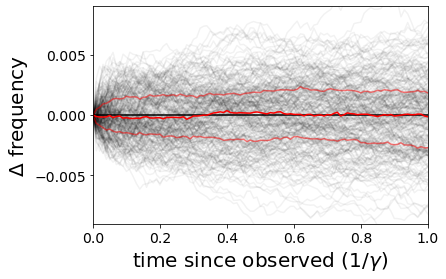

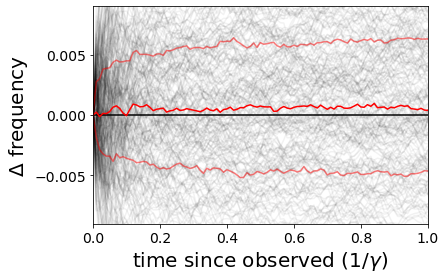

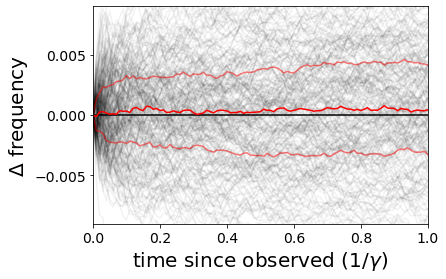

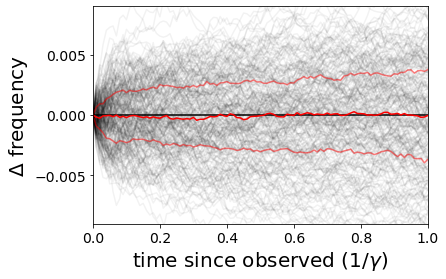

In [26]:
for i,currminfreq in enumerate(minfreqvec):
    for j,currcum in enumerate(mincumvec):
        print(currminfreq,currcum)
        printstr = '../figures/growthbias_split6_'+str(currcum)+'_'+str(currminfreq)+'.pdf'
        currdeltavar = alldeltavar[i,j]
        valmed = np.quantile(currdeltavar,.5,axis=0)
        val25 = np.quantile(currdeltavar,.25,axis=0)
        val75 = np.quantile(currdeltavar,.75,axis=0)
        fig,ax = plt.subplots()

        for curridx in range(np.shape(currdeltavar)[0]):
            ax.plot(tvec,currdeltavar[curridx,:],color='black',alpha=.05)
        plt.axhline(y=0, color='black', linestyle='-')
        ax.plot(tvec,valmed,color='red')
        ax.plot(tvec,val25,color='red',alpha=.5)
        ax.plot(tvec,val75,color='red',alpha=.5)
        ax.set_xlabel('time since observed (1/$\gamma$)',fontsize=20)
        ax.set_ylabel('$\Delta$ frequency',fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.set_xlim([0,1])
        ax.set_ylim((-.009,.009))
        #plt.savefig(printstr,bbox_inches='tight')